In [1]:
import chromadb
import json
import pandas as pd
from chromadb.utils.data_loaders import ImageLoader
from weavingtools.embedding_tools import SigLIPEmbedder
from weavingtools.weaving_tools import plot_query_results
import scipy.spatial as sp
import seaborn as sns
import numpy as np
sns.set()

/Users/kasparbeelen/anaconda3/envs/ce/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="ce_comms_db")

data_loader = ImageLoader()

collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

# Check database

In [3]:
collection_df = pd.read_csv('data/communications_data.csv')

In [4]:
collection_df

,Unnamed: 0,record_id,name,description,taxonomy,img_loc,img_name,img_path,downloaded,base_url,img_url
0,0,co8413501,Broadcast cartridge used by Radio Manchester t...,Broadcast cartridge used by Radio Manchester t...,audio tape; sound recording; <information arte...,204/255/medium_cd0620_049_100527_2005_86_35_Pr...,204|255|medium_cd0620_049_100527_2005_86_35_Pr...,smg_imgs/204|255|medium_cd0620_049_100527_2005...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
1,1,co8409836,RadioSpares Preset radio component,RadioSpares Preset radio component,NaN,209/376/medium_cd0472_015_081216_1996_10_507_F...,209|376|medium_cd0472_015_081216_1996_10_507_F...,smg_imgs/209|376|medium_cd0472_015_081216_1996...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
2,2,co8409837,RadioSpares Preset radio component,RadioSpares Preset radio component,NaN,209/377/medium_cd0472_016_081216_1996_10_508_F...,209|377|medium_cd0472_016_081216_1996_10_508_F...,smg_imgs/209|377|medium_cd0472_016_081216_1996...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
3,3,co8417687,Mercury tube switch,Mercury tube switch,NaN,126/903/medium_cd0701_033_121212_2003_22_120_8...,126|903|medium_cd0701_033_121212_2003_22_120_8...,smg_imgs/126|903|medium_cd0701_033_121212_2003...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
4,4,co8419534,Thermionic triode valve,Thermionic triode valve,electrical component; component parts; <object...,475/202/medium_SMG00243587.jpg,475|202|medium_SMG00243587.jpg,smg_imgs/475|202|medium_SMG00243587.jpg,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
...,...,...,...,...,...,...,...,...,...,...,...
5127,1340,T.2019.93,NaN,Colour wheel for a colour sequential televisio...,NaN,PF1000462,PF1000462.jpg,nms_imgs/PF1000462.jpg,True,https://www.nms.ac.uk/search.axd?command=getco...,https://www.nms.ac.uk/search.axd?command=getco...
5128,1341,T.2019.143,NaN,Wire broadcast system loudspeaker unit WB1400 ...,NaN,PF1097157,PF1097157.jpg,nms_imgs/PF1097157.jpg,True,https://www.nms.ac.uk/search.axd?command=getco...,https://www.nms.ac.uk/search.axd?command=getco...
5129,1342,T.2021.2,NaN,"Scale model of cable laying ship CS Alert, con...",NaN,PF1028391,PF1028391.jpg,nms_imgs/PF1028391.jpg,True,https://www.nms.ac.uk/search.axd?command=getco...,https://www.nms.ac.uk/search.axd?command=getco...
5130,1343,T.2021.34.1,NaN,"Manual typewriter Olympia Model 8, c. 1947",NaN,PF1089793,PF1089793.jpg,nms_imgs/PF1089793.jpg,True,https://www.nms.ac.uk/search.axd?command=getco...,https://www.nms.ac.uk/search.axd?command=getco...


In [5]:
collection_df.shape[0], collection_db.count()

(5132, 37219)

# Compare a pair items

In [6]:
data = collection_db.get()# where={'collection':'smg'}

In [7]:
rids = [record['record_id'] for record in data['metadatas']]
ids = data['ids']

In [8]:
r1 = collection_db.get(where={'record_id':rids[1000]},include=['embeddings','metadatas'])
r2 = collection_db.get(where={'record_id':rids[8003]},include=['embeddings','metadatas'])

In [9]:
im_1 = [r['input_modality'] for r in r1['metadatas']]
im_2 = [r['input_modality'] for r in r2['metadatas']]

In [10]:
r1_emb = np.matrix(r1['embeddings'])
r2_emb = np.matrix(r2['embeddings'])

In [11]:
mult = 1 - sp.distance.cdist(r1_emb,r2_emb, 'cosine')

<Axes: >

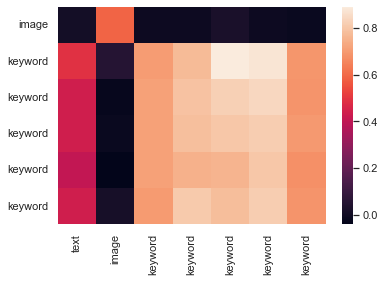

In [12]:
sns.set(rc={'figure.figsize':(7.7,6.27)})
sns.heatmap(mult, yticklabels=im_1, xticklabels=im_2)

# Collection Level Comparison

In [13]:
filter_smg = {
    "$and": [
        {
            "input_modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}


smg_data = collection_db.get(
                where=filter_smg,
                include=['embeddings','metadatas']

                    )

filter_nms = {
    "$and": [
        {
            "input_modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "nms"
            }
        }
    ]
}

nms_data = collection_db.get(
                where=filter_nms,
                include=['embeddings','metadatas']
            )

In [14]:
len(smg_data['embeddings'])

3764

In [15]:
smg_ids = smg_data['ids']
nms_ids = nms_data['ids']

In [16]:
smg_rids = [record['record_id'] for record in smg_data['metadatas']]
nms_rids = [record['record_id'] for record in nms_data['metadatas']]

In [26]:
smg_emb = np.matrix(smg_data['embeddings'])
nms_emb = np.matrix(nms_data['embeddings'])
image_similarities = 1 - sp.distance.cdist(smg_emb,nms_emb, 'cosine')

<Axes: >

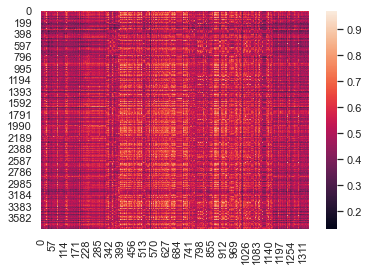

In [27]:
sns.heatmap(image_similarities)

<Axes: >

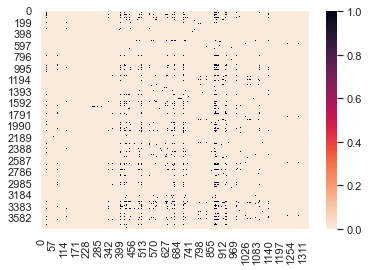

In [28]:
image_similarities[image_similarities >= .75] = 1
image_similarities[image_similarities < .75] = 0
sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

In [ ]:
image_similarities.sum(axis=1).sum()

In [ ]:
image_similarities.sum(axis=1).sum()/(image_similarities.shape[0]*image_similarities.shape[1])

# Network Visualisations

In [ ]:
smg_node_ids = list(np.where(image_similarities.sum(axis=1) > 0)[0])
nms_node_ids = list(np.where(image_similarities.sum(axis=0) > 0)[0])

In [ ]:
len(smg_node_ids), len(nms_node_ids)

In [ ]:
smg_mapping = {i:j for i,j in zip(range(len(smg_data['embeddings'])),smg_rids)}
nms_mapping = {i:j for i,j in zip(range(len(nms_data['embeddings'])),nms_rids)}

In [ ]:
image_similarities.sum(axis=0).sum()

In [ ]:
len(np.where(image_similarities > 0)[0])

In [ ]:
edges = [(i,j) for i,j in zip(*np.where(image_similarities > 0))]
edges[:10]

In [ ]:
len(edges)

In [ ]:
from pyvis.network import Network
net = Network(height="750px", 
              width="100%", 
              bgcolor="#222222", 
              font_color="white", 
              cdn_resources='remote', 
              #filter_menu=True, 
              #select_menu=True,
              notebook=True)


In [ ]:
from tqdm.notebook import tqdm
for nid in tqdm(smg_node_ids):
    net.add_node(smg_mapping[nid],shape='image',  
                image = collection_df[collection_df.record_id==smg_mapping[nid]].img_url.values[0]
                )
for nid in tqdm(nms_node_ids):
    net.add_node(nms_mapping[nid], shape='image',  
                 image = collection_df[collection_df.record_id==nms_mapping[nid]].img_url.values[0]
                )#
        # ['metadatas'][0]['img_url'],
        # label=el['ids'][0],           
        # title = el['documents'][0])
        
for i,j in edges:
    net.add_edge(smg_mapping[i], 
                 nms_mapping[j])
                 # weight=nn['distances'][0][i])


In [ ]:
len(net.nodes),len(net.edges)

In [ ]:
net.show("smg_nms_network.html")

# Projection

In [29]:
from nomic import atlas

In [30]:
%%bash
nomic login pyKINnSOXSivweuAXxprY7j8NtVFI88WC7AeE3BnLAmQZ

In [36]:
smg_emb = np.matrix(smg_data['embeddings'])
nms_emb = np.matrix(nms_data['embeddings'])
embeddings = np.concatenate([smg_emb,nms_emb])
embeddings = np.array(embeddings)
embeddings.shape

(5109, 768)

In [37]:
embeddings

array([[ 0.00720901, -0.01459423,  0.01227817, ...,  0.00578243,
        -0.00771861, -0.01358625],
       [ 0.02696303, -0.01108431, -0.00431297, ...,  0.02147233,
         0.05140077, -0.04328395],
       [ 0.0094307 , -0.00807236,  0.03060564, ...,  0.00439771,
         0.05495163, -0.02080899],
       ...,
       [ 0.0247112 , -0.00688281,  0.00326415, ...,  0.00122804,
        -0.00210343,  0.01926854],
       [ 0.03234725, -0.00376364,  0.02499698, ...,  0.0145528 ,
         0.0438705 ,  0.01756027],
       [-0.0043002 ,  0.00152679, -0.01923193, ..., -0.00192627,
         0.02066798, -0.02183465]])

In [39]:
smg_metadata = [{'id':i,
                 'record_id':r['record_id'],
                 'url':r['img_url'],
                 'collection':r['collection']
                        }
                    for i,r in enumerate(smg_data['metadatas'])]

nms_metadata = [{'id':i+len(smg_metadata),
                 'record_id':r['record_id'],
                 'url':r['img_url'],
                 'collection':r['collection']
                        }
                    for i,r in enumerate(nms_data['metadatas'])]

In [40]:
metadata = smg_metadata + nms_metadata
print(len(embeddings),len(metadata))

5109 5109


In [41]:
project = atlas.map_embeddings(embeddings=embeddings,
                                data=metadata,
                                id_field='id',
                                name='CE NMS SMG',
                                colorable_fields=['collection'],
                                reset_project_if_exists=True)

2024-02-13 17:12:56.432 | INFO     | nomic.project:_create_project:790 - Creating project `CE NMS SMG` in organization `kasparvonbeelen`
2024-02-13 17:12:57.458 | INFO     | nomic.atlas:map_embeddings:108 - Uploading embeddings to Atlas.
2024-02-13 17:12:57.515 | WARNING  | nomic.project:_validate_and_correct_arrow_upload:261 - id_field is not a string. Converting to string from int32
3it [00:11,  3.69s/it]                                                          
2024-02-13 17:13:08.617 | INFO     | nomic.project:_add_data:1422 - Upload succeeded.
2024-02-13 17:13:08.620 | INFO     | nomic.atlas:map_embeddings:127 - Embedding upload succeeded.
2024-02-13 17:13:10.034 | INFO     | nomic.project:create_index:1132 - Created map `CE NMS SMG` in project `CE NMS SMG`: https://atlas.nomic.ai/map/915f824b-3123-4928-9747-50cdab194790/24325026-a90e-483d-a1e4-d4eeba710f81
2024-02-13 17:13:10.036 | INFO     | nomic.atlas:map_embeddings:140 - CE NMS SMG: https://atlas.nomic.ai/map/915f824b-3123-49